# Optimizing Model Prediction

In previous machine learning projects, the focus was on constructing a single model and implementing various Machine Learning methodologies.

We'll be taking on a different approach in this project. Instead of going with a single model, we'll start with a reference model (standard linear regression model) and then iterate on it using other Machine Learning techniques to optimize it. 

The machine learning tasks will be predicting the extent of fire damage to a forest using the [Forest Fires](https://archive.ics.uci.edu/ml/datasets/Forest+Fires) dataset from the UCI Machine Learning Repository.

This dataset contains information on fires, along with the resulting damage and associated meteorological data. We want to know how these characteristics might be useful in predicting future fire damage.

## Building the Reference Model

In [72]:
# importing libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score 

import seaborn as sns

In [34]:
# loading in the local insurance dataset
fires = pd.read_csv('..\\Datasets\\fires.csv') # avoiding "Unnamed:0" artifact

fires.drop('Unnamed: 0', inplace=True, axis=1)
#checking first five
fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


## Data Processing

Before preceding with building the model, we should address the missing data present.

In [36]:
# dataset column information
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    469 non-null    float64
 5   DMC     496 non-null    float64
 6   DC      474 non-null    float64
 7   ISI     515 non-null    float64
 8   temp    496 non-null    float64
 9   RH      487 non-null    float64
 10  wind    482 non-null    float64
 11  rain    485 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(9), int64(2), object(2)
memory usage: 52.6+ KB


Looks to be quite a bit of missing data. Only five of thirteen columns don't have null values (`NaN`): `X`, `Y`, `month`, `day`, and `area`. 

In [37]:
fires['month'].value_counts(normalize=True, dropna=False)

month
aug    0.355899
sep    0.332689
mar    0.104449
jul    0.061896
feb    0.038685
jun    0.032882
oct    0.029014
apr    0.017408
dec    0.017408
jan    0.003868
may    0.003868
nov    0.001934
Name: proportion, dtype: float64

There's obviously some trend during the year where certain months/seasons happen to have more forest fire instances than others. This trend is more evident when plotting forest fire instances while the months are in order.

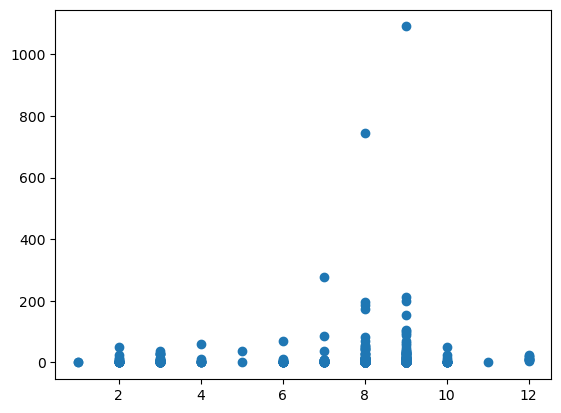

In [38]:
# mapping months to numerical equivalent
fires['num_month'] = fires['month'].map({
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12,
})

# plotting forest fire's area to respective month (ordered by month) 
plt.scatter(x='num_month', y='area', data=fires.sort_values(by='num_month'))

As one would imagine, forest fires are more pervasive during the second half of the summer. We'll add a `summer` column indicating if the observation took place in June, July, August or September. (Though not typically considered a Summer month, September will be included in this observation given the high forest fire frequency and area).  

In [39]:
fires['summer'] = fires['month'].apply(lambda x: 1 if x in ['jun', 'july', 'aug', 'sep'] else 0)

In [40]:
fires['summer'].value_counts(dropna=False)

summer
1    373
0    144
Name: count, dtype: int64

In [41]:
fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,num_month,summer
0,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0,3,0
1,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0,10,0
2,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0,10,0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0,3,0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0,3,0


array([[<Axes: title={'center': 'area'}>]], dtype=object)

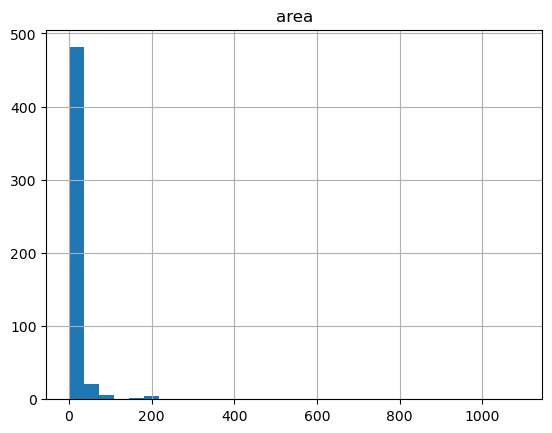

In [42]:
fires.hist('area', bins=30)

The outcome is highly right-skewed with extremely damaging fires. Furthermore, many of the rows have outcome values that are zero or near-zero. It might be worth it to log-transform the data. Note though that some of the outcomes are actually 0, so we can add 1 to prevent any errors. Recall that $log(0)$ is undefined.

array([[<Axes: title={'center': 'log_area'}>]], dtype=object)

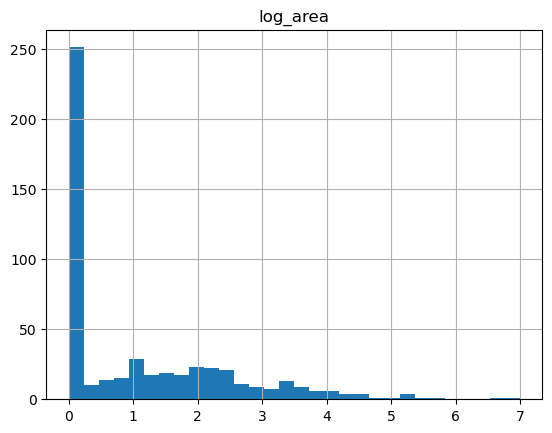

In [43]:
fires['log_area'] = np.log(fires['area'] + 1)

fires.hist('log_area', bins=30)

We'll impute the columns with missing values using the scikit-learn `impute` class `KNNImpute` (K-Nearest Neighbors) method.

In [44]:
imp = KNNImputer(missing_values=np.nan, n_neighbors=3)

fires_na = fires[fires.columns[4:12]] #from columns 'FFMC' to 'rain'
imputed = pd.DataFrame(imp.fit_transform(fires_na), columns=fires.columns[4:12])
imputed

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0
...,...,...,...,...,...,...,...,...
512,81.6,56.700000,665.600000,1.9,27.8,32.0,2.700000,0.0
513,81.6,56.700000,665.600000,1.9,21.9,71.0,5.800000,0.0
514,81.6,56.700000,665.600000,1.9,21.2,70.0,6.700000,0.0
515,94.4,146.000000,614.700000,11.3,25.6,42.0,4.000000,0.0


### Examining Outliers

Seeing as this data is not normally distributed, we'll focus on using boxplots to help us identify outliers.

<Axes: >

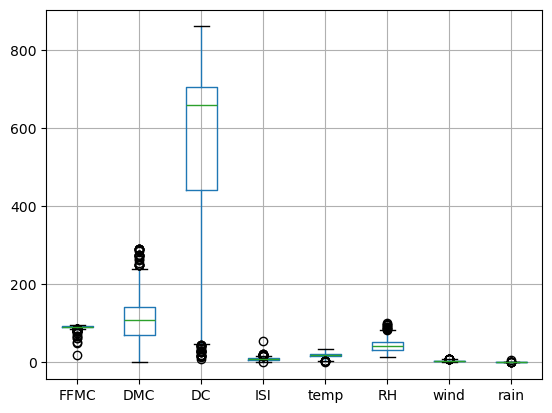

In [45]:
imputed.boxplot(column=imputed.columns.to_list())

In [46]:
fires.describe()[['FFMC','DMC','DC','ISI','temp','RH','wind','rain']]

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,469.000000,496.000000,474.000000,515.000000,496.000000,487.000000,482.000000,485.000000
mean,90.580384,111.195363,550.673418,9.018835,18.884677,44.381930,4.021784,0.023093
std,5.698137,64.008450,246.061309,4.564890,5.748318,16.180372,1.794460,0.305532
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000
25%,90.200000,70.800000,441.200000,6.450000,15.475000,33.000000,2.700000,0.000000
50%,91.600000,108.300000,664.500000,8.400000,19.300000,42.000000,4.000000,0.000000
75%,92.800000,141.575000,713.900000,10.750000,22.725000,53.500000,4.900000,0.000000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000


In [47]:
imputed.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.658930,110.886912,544.791231,9.016054,18.896970,44.355255,4.018569,0.021663
std,5.494697,63.452541,244.178695,4.556973,5.774151,15.884310,1.772620,0.295959
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000
25%,90.300000,70.800000,442.100000,6.500000,15.600000,33.000000,2.700000,0.000000
50%,91.600000,108.300000,658.200000,8.400000,19.300000,42.000000,4.000000,0.000000
75%,92.800000,141.300000,706.700000,10.700000,22.800000,53.000000,4.900000,0.000000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000


It does appear that there some outliers in the dataset. Let's get more concrete counts for each.

In [48]:
for col in imputed:
    quartiles_o = np.nanpercentile(fires[col], [25, 50, 75]) # percentiles of fires[col] ignoring nan values
    quartiles_i = np.percentile(imputed[col], [25, 50, 75])
    
    iqr_o = quartiles_o[2] - quartiles_o[0]
    iqr_i = quartiles_i[2] - quartiles_i[0]
    
    lower_bound_o= quartiles_o[0] - (1.5 * iqr_o)
    lower_bound_i= quartiles_i[0] - (1.5 * iqr_i)
    
    upper_bound_o = quartiles_o[2] + (1.5 * iqr_o)
    upper_bound_i = quartiles_i[2] + (1.5 * iqr_i)
    
    num_outliers_o =sum((fires[col] < lower_bound_o) | (fires[col] > upper_bound_o))
    num_outliers_i =sum((imputed[col] < lower_bound_i) | (imputed[col] > upper_bound_i))
    
    col_max_o= fires[col].max()
    col_max_i = imputed[col].max()

    print(f'{col} \n Original:  -Number of Outliers: {num_outliers_o}\n Imputed:   -Number of Outliers: {num_outliers_i} ')

FFMC 
 Original:  -Number of Outliers: 49
 Imputed:   -Number of Outliers: 53 
DMC 
 Original:  -Number of Outliers: 22
 Imputed:   -Number of Outliers: 22 
DC 
 Original:  -Number of Outliers: 15
 Imputed:   -Number of Outliers: 25 
ISI 
 Original:  -Number of Outliers: 23
 Imputed:   -Number of Outliers: 23 
temp 
 Original:  -Number of Outliers: 1
 Imputed:   -Number of Outliers: 9 
RH 
 Original:  -Number of Outliers: 9
 Imputed:   -Number of Outliers: 10 
wind 
 Original:  -Number of Outliers: 12
 Imputed:   -Number of Outliers: 13 
rain 
 Original:  -Number of Outliers: 8
 Imputed:   -Number of Outliers: 8 


It would seem that `KNNImputed` contributed to additional "outlier" entries in handful of columns. The most egregious instances are columns `DC` and `temp`. We'll have to be mindful of this when building our model.

**To address this, we'll reproduce the model using the imputed dataframe (`imputed`) with the outliers left as is, and compare it to another model using an instance of `imputed` with the extra outliers removed.**     

Standardizing the features to have a mean of 0 and a standard deviation of 1.

In [52]:
scaler = StandardScaler()
scaled = scaler.fit_transform(imputed)
scaled = pd.DataFrame(scaled, columns=fires.columns[4:12])
final = pd.concat([fires['summer'], scaled], axis=1)

final

,summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268
...,...,...,...,...,...,...,...,...,...
512,1,-1.650265,-0.854803,0.495235,-1.563087,1.543370,-0.778581,-0.744573,-0.073268
513,1,-1.650265,-0.854803,0.495235,-1.563087,0.520585,1.679050,1.005944,-0.073268
514,1,-1.650265,-0.854803,0.495235,-1.563087,0.399238,1.616034,1.514159,-0.073268
515,1,0.681511,0.553912,0.286579,0.501683,1.161993,-0.148419,-0.010485,-0.073268


## Subset Selection

In [63]:
from sklearn.feature_selection import SequentialFeatureSelector

y = fires["log_area"]

sfs_model = LinearRegression()
sfs_model2 = LinearRegression()
sfs_model3 = LinearRegression()

# selecting 2 features 
forward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="forward")

# selecting 4 features 
forward4 = SequentialFeatureSelector(estimator=sfs_model2,
                                     n_features_to_select=4, 
                                     direction="forward")

# selecting 6 features 
forward6 = SequentialFeatureSelector(estimator=sfs_model3,
                                       n_features_to_select=6, 
                                       direction="forward")

forward2.fit(final, y)
forward4.fit(final, y)
forward6.fit(final, y)

print("Features selected in 2 feature model:", forward2.get_feature_names_out())
print("Features selected in 4 feature model:", forward4.get_feature_names_out())
print("Features selected in 6 feature model:", forward6.get_feature_names_out())

Features selected in 2 feature model: ['FFMC' 'DC']
Features selected in 4 feature model: ['summer' 'FFMC' 'DC' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


In [64]:
backward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="backward")

backward4 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=4, 
                                     direction="backward")

backward6 = SequentialFeatureSelector(estimator=sfs_model,
                                       n_features_to_select=6, 
                                       direction="backward")

backward2.fit(final, y)
backward4.fit(final, y)
backward6.fit(final, y)

print("Features selected in 2 feature model:", backward2.get_feature_names_out())
print("Features selected in 4 feature model:", backward4.get_feature_names_out())
print("Features selected in 6 feature model:", backward6.get_feature_names_out())

Features selected in 2 feature model: ['DC' 'wind']
Features selected in 4 feature model: ['summer' 'FFMC' 'DC' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


Based on the features chosen by forward and backward selection, it seems like `DC`, `wind` and `FFMC` seem to be the most impactful on predicting `log_area`.

In [75]:
fw2_model = LinearRegression() # .fit(final[forward2.get_feature_names_out()], y)
fw4_model = LinearRegression() # .fit(final[forward4.get_feature_names_out()], y)
fw6_model = LinearRegression() # .fit(final[forward6.get_feature_names_out()], y)

bw2_model = LinearRegression() # .fit(final[backward2.get_feature_names_out()], y)
bw4_model = LinearRegression() # .fit(final[backward4.get_feature_names_out()], y)
bw6_model = LinearRegression() # .fit(final[backward6.get_feature_names_out()], y)

## More Candidate Models
Another approach we might consider taking is using regularized versions of linear regression. Fires have many factors that can increase the damaage they have, so it seems unhelpful to restrict our model to a univariate, non-linear model. We will consider incorporating some more flexible models as candidate models: polynomials and splines.

Incorporating this extra flexibility can come at a price: an increased chance of overfitting. Including higher polynomials, more knots, or many features in the model may help with predictive ability on the training set, but we may be setting ourselves up for poor performance on the test set. In the case of many features, we can also turn to regularization to account for this.

In [69]:
ridge = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge.fit(final, y)
lasso.fit(final, y)

print("Ridge tuning parameter: ", ridge.alpha_)
print("LASSO tuning parameter: ", lasso.alpha_)

print("Ridge coefficients: ", ridge.coef_)
print("LASSO coefficients: ", lasso.coef_)

Ridge tuning parameter:  2433.189189189189
LASSO tuning parameter:  10000.0
Ridge coefficients:  [ 0.00259758  0.00904404  0.01305212  0.01340925 -0.00576429  0.00888701
 -0.00989237  0.01647297  0.00530744]
LASSO coefficients:  [ 0.  0.  0.  0. -0.  0. -0.  0.  0.]


The LASSO tuning parameter always seems to be on the extreme. Given the outcome has many small values, it suggests that having no features at all is better than having any. We'll try to hone in on a better tuning parameter value below by choosing a smaller range to pick from.

In [70]:
ridge = RidgeCV(alphas = np.linspace(1500, 2500, num=1000))
ridge.fit(final, y)
print("Ridge tuning parameter: ", ridge.alpha_)

Ridge tuning parameter:  2433.933933933934


We'll use this value in k-fold cross-validation, rounded to the hundredths place. We'll use a ridge regression and choose not to use a LASSO model here since the regularization results aren't helpful here.

In [76]:
reference = LinearRegression()
reference_cv = cross_val_score(reference, final[["wind", "temp"]], y, cv = 5, scoring = "neg_mean_squared_error")
fw2_cv = cross_val_score(fw2_model, final[forward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw4_cv = cross_val_score(fw4_model, final[forward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw6_cv = cross_val_score(fw6_model, final[forward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw2_cv = cross_val_score(bw2_model, final[backward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw4_cv = cross_val_score(bw4_model, final[backward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw6_cv = cross_val_score(bw6_model, final[backward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
ridge_cv = cross_val_score(ridge, final, y, cv = 5, scoring = "neg_mean_squared_error")

print("Reference Model, Avg Test MSE: ", np.mean(reference_cv), " SD: ", np.std(reference_cv))
print("Forward-2 Model, Avg Test MSE: ", np.mean(fw2_cv), " SD: ", np.std(fw2_cv))
print("Forward-4 Model, Avg Test MSE: ", np.mean(fw4_cv), " SD: ", np.std(fw4_cv))
print("Forward-6 Model, Avg Test MSE: ", np.mean(fw6_cv), " SD: ", np.std(fw6_cv))
print("Backward-2 Model, Avg Test MSE: ", np.mean(bw2_cv), " SD: ", np.std(bw2_cv))
print("Backward-4 Model, Avg Test MSE: ", np.mean(bw4_cv), " SD: ", np.std(bw4_cv))
print("Backward-6 Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))
print("Ridge Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))

Reference Model, Avg Test MSE:  -2.204650013004116  SD:  1.060040355378637
Forward-2 Model, Avg Test MSE:  -2.1735431721198535  SD:  1.0208083278697586
Forward-4 Model, Avg Test MSE:  -2.182263721721556  SD:  1.0104566574859848
Forward-6 Model, Avg Test MSE:  -2.206304504495447  SD:  1.0008801903587727
Backward-2 Model, Avg Test MSE:  -2.173357302739327  SD:  1.0038109503795958
Backward-4 Model, Avg Test MSE:  -2.182263721721556  SD:  1.0104566574859848
Backward-6 Model, Avg Test MSE:  -2.206304504495447  SD:  1.0008801903587727
Ridge Model, Avg Test MSE:  -2.206304504495447  SD:  1.0008801903587727


Among our candidate models, the backward selection model using 2 features performs the best, with an average MSE of -2.17. However, note that this is on the log-scale, so this suggests that the predictions are off by a magnitude of about 2. On the surface, this suggests that the models overall are not good predictors.

However, this problem is known to be a difficult one. The extreme skew in the outcome hurts many of the assumptions needed by linear models. We hope that this showcases that machine learning is not a silver bullet. Several problems have characteristics that make prediction difficult.